# DS4440 - Practical Neural Networks
## Week 1 : Perceptron (Classification & Regression)

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement

Imagine we work for a **medical insurance company** that wants to better understand its customers to improve its services. To achieve this, the company has compiled a dataset containing key information about its clients. By analyzing features such as age, BMI, and region, we can uncover trends and patterns that can inform decisions about insurance plans, marketing strategies, and risk assessment.

Our goal is to explore various predictive tasks using this dataset to gain deeper insights into the customers. These tasks include:

1. **Classification**: Predicting if an individual is a smoker or not.   
2. **Regression**: Estimating the insurance cost for an individual using other features.

To accomplish these tasks, we will use the **Perceptron algorithm**, one of the simplest and most foundational types of neural networks. Despite its simplicity, the Perceptron introduces essential concepts in machine learning and classification, making it a great starting point for understanding how models learn from data.

### About the Dataset

The dataset includes the following features for each individual:  
- **Age**: The age of the individual.  
- **Sex**: The gender of the individual (male or female).  
- **BMI**: Body Mass Index, a measure of body fat based on height and weight.  
- **Children**: Number of children covered by the insurance plan.  
- **Smoker**: Whether the individual is a smoker (yes or no).  
- **Region**: The individual's region of residence (e.g., northeast, southeast, etc.).  
- **Charges**: The medical insurance cost for the individual.

By the end of this notebook, you will understand how to use the Perceptron algorithm to perform both classification and regression tasks, providing a foundational understanding of machine learning.  

Let's dive in!


## Setup and Load libraries

The below cell is written to ensure the right way of loading the helper file that has all the training and modularized code for the course

In [1]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)

In [2]:
! pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In this notebook, we'll walk through **both** a classification and regression pipeline using **the same dataset** (Medical Insurance Costs). We'll follow the **six** key sections below(these sections will be present in every notebook moving forward):
1. **Data Gathering**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Understanding & Preprocessing**
4. **Model Building**
5. **Model Validation**
6. **Results and Conclusions**

## Data Gathering

In [4]:
df = pd.read_csv("../../Datasets/medical_insurance.csv")

In [5]:
df.head() # This displays the 5 rows of the dataset by default

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis (EDA)

### Check the size of the dataset

In [6]:
size = df.shape
print(f"The dataset has {size[0]} rows and {size[1]} columns")

The dataset has 2772 rows and 7 columns


### Check if NULL/Empty cells are present in the dataset

It checks every column for null values in the dataset and returns the count of all the null values in each column

In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Check the datatypes of each column in the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


### Explore the statistics of the numerical columns in the dataset
This cell provides a summary of statistics (count, mean, std, min, 25%, 50%, 75%, and max) for numerical columns in a DataFrame.

In [9]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


### Explore the statistics of the categorical columns in the dataset

In [10]:
df.describe(include='object')

,sex,smoker,region
count,2772,2772,2772
unique,2,2,4
top,male,no,southeast
freq,1406,2208,766


### Check if there are duplicates in the dataset

In [11]:
df.duplicated()

print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 1435


### Drop the duplicates

In [12]:
print(f'before: {df.duplicated().sum()}')
df.drop_duplicates(inplace = True, ignore_index = True)
print(f'after: {df.duplicated().sum()}')

before: 1435
after: 0


### Explore the class distribution in all the categorical columns

In [13]:
categorical_columns = ['sex', 'smoker', 'region']

for column in categorical_columns:
    print(f"Class distribution for {column}:")
    print(df[column].value_counts())
    print()

Class distribution for sex:
sex
male      675
female    662
Name: count, dtype: int64

Class distribution for smoker:
smoker
no     1063
yes     274
Name: count, dtype: int64

Class distribution for region:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



### Understand the dataset through visualizations

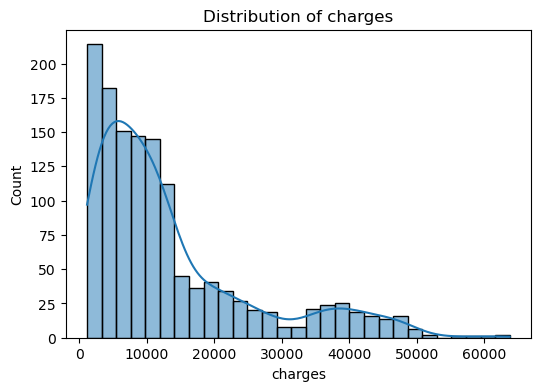

In [14]:
# distribution of charges after scaling numeric cols (though 'charges' itself wasn't scaled)
plt.figure(figsize=(6,4))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of charges')
plt.show()

The following observations are noted below :
1. The distribution is right-skewed (positive skew), meaning most data points are concentrated at lower charge values, while a smaller number of data points represent much higher charges.
2. The spread of the data shows variability in charges, with most values falling below 20,000 and a few outliers extending up to 60,000.

In [15]:
# distribution of charges after scaling numeric cols (though 'charges' itself wasn't scaled)
numeric_cols = ['age','bmi','children']
bins = [0, 30, 60, 100]
labels = ['low', 'med', 'high']
df["age_bucket"] = pd.cut(df["age"], bins=bins, labels=labels)

In [16]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_bucket
0,19,female,27.900,0,yes,southwest,16884.92400,low
1,18,male,33.770,1,no,southeast,1725.55230,low
2,28,male,33.000,3,no,southeast,4449.46200,low
3,33,male,22.705,0,no,northwest,21984.47061,med
4,32,male,28.880,0,no,northwest,3866.85520,med


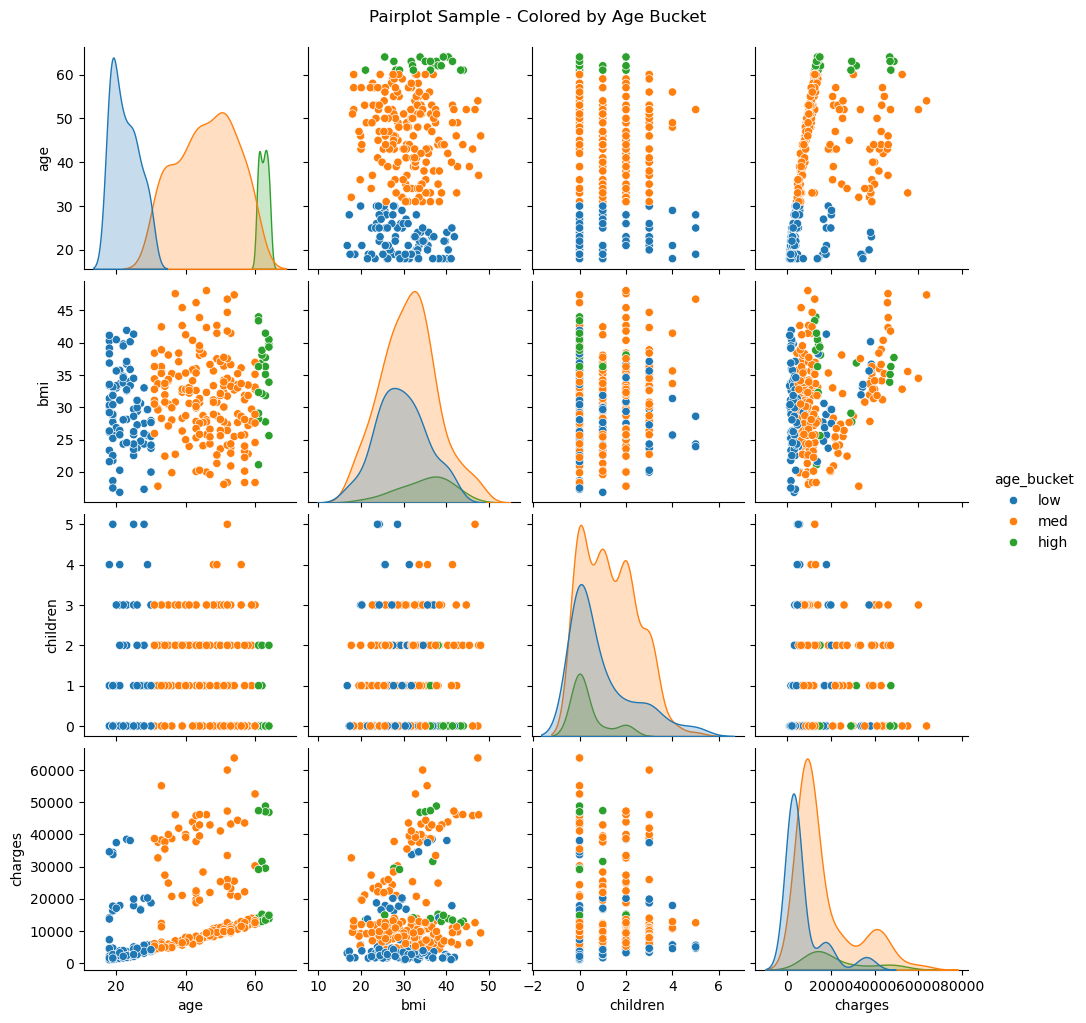

In [17]:
# pairplot to see relationships
sample_df = df[['age','bmi','children','charges','age_bucket']].sample(300, random_state=42)
sns.pairplot(sample_df, hue='age_bucket')
plt.suptitle('Pairplot Sample - Colored by Age Bucket', y=1.02)
plt.show()

From the above visulaizations, we can see the following :
1. As the age increases, the cost of the insurance increases.
2. If your BMI is in the healthy range, you pay lesser insurance fee.
3. Number of children have little to no effect on medical insurance charges.
4. In a real world scenario, very few people have more than 3 children so there are no valuable insights we can gather from the children column

In [18]:
number_column = df.select_dtypes(include=['int64' , 'float64'])
object_column = df.select_dtypes(include='object')

In [19]:
pd.crosstab(df['sex'] , df['smoker'])

smoker,no,yes
sex,,
female,547,115
male,516,159


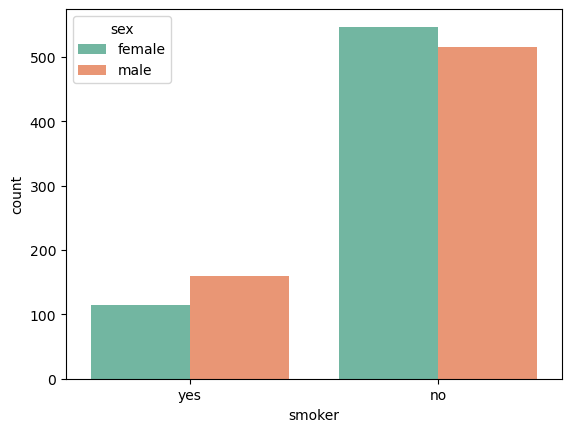

In [20]:
sns.countplot(data =df , x = 'smoker' , hue = 'sex' , palette='Set2')
plt.show()

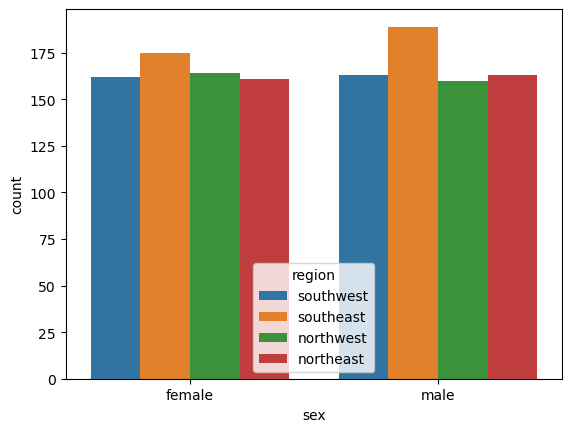

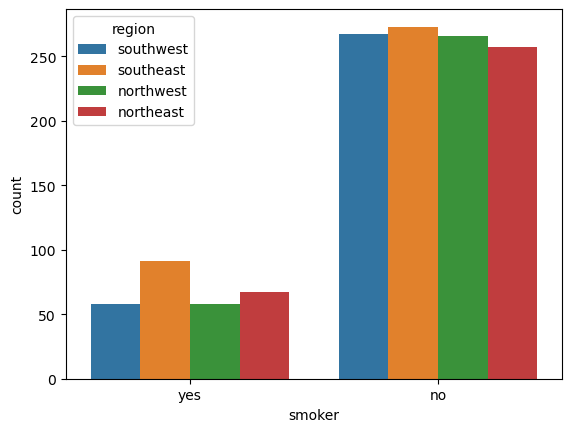

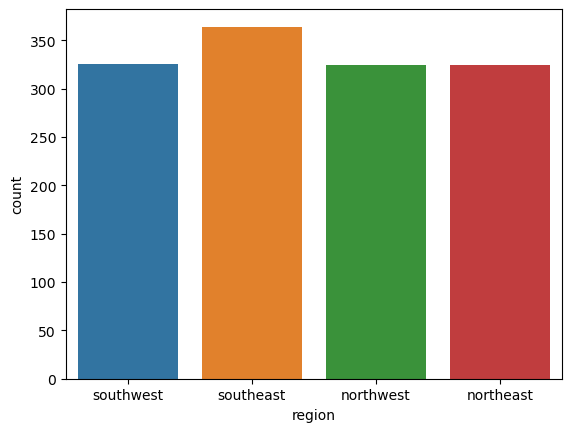

In [21]:
for column in object_column:
    sns.countplot(data = df , x = column  ,hue = 'region')
    plt.show()

## Feature Understanding & Preprocessing

#### Data Preparation for the Model

Before feeding the data into the model, it is essential to perform some preprocessing steps to ensure the data is in a suitable format for training. These steps are crucial for the Perceptron algorithm to converge effectively and provide meaningful results. The key preprocessing steps include:

#### 1. Normalization of Numerical Columns
Normalization is required because:
- **Different scales of features**: The numerical features, such as `age`, `bmi`, and `charges`, may have significantly different ranges. When features are on different scales, the learning algorithm may prioritize certain features over others, leading to biased learning. For example, a large feature like `charges` may dominate the model's learning process if not normalized.
- **Speed of Convergence**: Perceptron and other gradient-based algorithms often perform better when the features are normalized. If one feature dominates due to its scale, the model might converge very slowly or get stuck in a local minimum.
- **Improved Performance**: Normalization ensures that all features contribute equally to the model’s learning process, allowing the algorithm to work more efficiently.

#### 2. One-Hot Encoding of Categorical Columns
One-hot encoding is required because:
- **Non-numeric data**: Machine learning models, including Perceptron, require numerical input. Categorical columns like `smoker` and `region` cannot be directly used by the model as they are non-numeric. One-hot encoding transforms these categorical variables into a series of binary columns, allowing the model to interpret them correctly.
- **Representation of categories**: One-hot encoding ensures that each category is represented as a separate binary feature, avoiding any ordinal or hierarchical assumptions that might be made by algorithms if the categories were represented as integers. For instance, treating the `smoker` feature as integers (1 for "yes", 0 for "no") may suggest an ordering (e.g., "yes" > "no"), which is incorrect in this context.
  
#### 3. Handling Missing or Erroneous Data
Handling missing or erroneous data is required because:
- **Ensuring completeness**: Most machine learning algorithms, including Perceptron, cannot handle missing values. If the dataset has missing values, the model may fail to train or produce unreliable predictions. It is crucial to impute or remove missing data to ensure that the model can process the data correctly.
- **Avoiding bias**: If missing data is ignored or handled improperly, it can introduce bias into the model, making the predictions inaccurate. For instance, simply removing rows with missing values may lead to biased results if the missing data is not missing at random.
  


#### Define the Feature and Target variables

In [22]:
# update the target variable for classification
X = df[['age', 'bmi', 'children', 'region', 'sex']]
y = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)  # binary encoding for 'smoker'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
X.head()

,age,bmi,children,region,sex
0,19,27.900,0,southwest,female
1,18,33.770,1,southeast,male
2,28,33.000,3,southeast,male
3,33,22.705,0,northwest,male
4,32,28.880,0,northwest,male


In [24]:
y

0       1
1       0
2       0
3       0
4       0
       ..
1332    0
1333    0
1334    0
1335    0
1336    1
Name: smoker, Length: 1337, dtype: int64

In [25]:
number_column = X.select_dtypes(include=['int64' , 'float64'])
object_column = X.select_dtypes(include='object')

In [26]:
numerical_features = list(number_column.columns) # We defined all numerical columns as number_column above in the notebook
numerical_transformer = StandardScaler()

# Categorical columns to one-hot encode
categorical_features = X.select_dtypes(include='object').columns  # We defined all categorical columns as object_column above in the notebook
categorical_transformer = OneHotEncoder(drop='first') # Adds new columns to the dataset

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(drop='first'), X.select_dtypes(include='object').columns)
    ]
)

# Fit and transform the entire dataset (excluding the target column, assuming it's 'sex')
X_transformed = preprocessor.fit_transform(X)

# Extract feature names for the transformed DataFrame
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_names) + list(categorical_names)

df_X_transformed = pd.DataFrame(X_transformed, columns= feature_names)

In [27]:
df_X_transformed.head(10) # Dataset ready to be fed to the model.

,age,bmi,children,region_northwest,region_southeast,region_southwest,sex_male
0,-1.440418,-0.453160,-0.909234,0.0,0.0,1.0,0.0
1,-1.511647,0.509422,-0.079442,0.0,1.0,0.0,1.0
2,-0.799350,0.383155,1.580143,0.0,1.0,0.0,1.0
3,-0.443201,-1.305052,-0.909234,1.0,0.0,0.0,1.0
4,-0.514431,-0.292456,-0.909234,1.0,0.0,0.0,1.0
5,-0.585661,-0.807363,-0.909234,0.0,1.0,0.0,0.0
6,0.482785,0.455307,-0.079442,0.0,1.0,0.0,0.0
7,-0.158282,-0.479397,1.580143,1.0,0.0,0.0,0.0
8,-0.158282,-0.136672,0.750351,0.0,0.0,0.0,1.0
9,1.480002,-0.790965,-0.909234,1.0,0.0,0.0,0.0


## Introduction to Perceptrons
The **Perceptron** is one of the simplest types of artificial neural networks. It was introduced by Frank Rosenblatt in 1958 and is designed to solve machine learning tasks.



The perceptron equation is typically described by:

$
\hat{y} = w^T x + b
$

where:

- \( $w_i$ \): Weight associated with feature \( $i$ \)  
- \( $x_i$ \): Value of feature \( $i$ \)  
- \( $b$ \): Bias term (an offset added to the weighted sum)  
- \( $\hat{y}$ \): Predicted output (a linear combination of inputs and weights, which is thresholded for classification)  

##### Additional Terms in the Training Process:

- \( $\alpha$ \): Learning rate (controls the step size during weight updates)  
- \( y \): Actual label (used to compute the error during training)

With a proper choice of activation/loss:
- It can **classify** binary or multi-class data (using logistic or softmax).
- It can **regress** continuous targets (using MSE loss).


<!-- ![Perceptron Diagram](perceptron.png) -->

![Perceptron Diagram](perceptron.gif)


### **Classification**

In this task, our goal is to predict whether an individual is a smoker or not.

### **Features Used for Prediction**
We will utilize the following features to make predictions:

1. **Age**: The age of the individual.
2. **BMI**: Body Mass Index, a measure of body fat based on height and weight.
3. **Children**: The number of children/dependents the individual has.
4. **Region**: The region of residence (e.g., northeast, northwest, southeast, southwest).
5. **Sex**: The gender of the individual (male or female).






#### Model Building Using PyTorch

In [28]:
# The Features that will be passed to the model.
X_transformed

array([[-1.44041773, -0.45315959, -0.90923416, ...,  0.        ,
         1.        ,  0.        ],
       [-1.51164747,  0.50942165, -0.07944162, ...,  1.        ,
         0.        ,  1.        ],
       [-0.79935006,  0.3831546 ,  1.58014347, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.51164747,  1.01448983, -0.90923416, ...,  1.        ,
         0.        ,  0.        ],
       [-1.29795825, -0.79752426, -0.90923416, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.55123139, -0.26129928, -0.90923416, ...,  0.        ,
         0.        ,  0.        ]])

In [29]:
# The Target Variable
y = np.array(y)
y

array([1, 0, 0, ..., 0, 0, 1])

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [31]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make it 2D for PyTorch
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [32]:
y_train

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [33]:
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # fully connected layer with 1 output

    def forward(self, x):
        x = self.fc(x)
        x = torch.sigmoid(x)  # sigmoid activation for binary classification
        return x

In [34]:
train_losses = [] # list to hold train loss values for each epoch
test_losses = [] # list to hold test loss values for each epoch

# train one epoch
def train_one_epoch(model, X_train, y_train, criterion, optimizer):
    model.train()  # set model to training mode
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward pass and optimization
    loss.backward()
    optimizer.step()

    return loss.item()

# evaluate the model
def evaluate_model(model, X_test, y_test, criterion):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)

        # convert probabilities to binary predictions
        preds = (outputs >= 0.5).float()

        # calculate metrics
        accuracy = accuracy_score(y_test.numpy(), preds.numpy())
        precision = precision_score(y_test.numpy(), preds.numpy())
        recall = recall_score(y_test.numpy(), preds.numpy())
        f1 = f1_score(y_test.numpy(), preds.numpy())

    return loss.item(), accuracy, precision, recall, f1

# training loop
def train_model(model, X_train, y_train, X_test, y_test, epochs, criterion, optimizer):
    for epoch in range(1, epochs + 1):
        # train the model for one epoch
        train_loss = train_one_epoch(model, X_train, y_train, criterion, optimizer)
        train_losses.append(train_loss)

        # print weights and biases every epoch
        weights = model.fc.weight.data
        biases = model.fc.bias.data
        print(f"Epoch {epoch}/{epochs}".center(50, "-"))
        print(f"  Weights: {weights}")
        print(f"  Biases: {biases}")
        print(f"  Training Loss: {train_loss:.4f}\n")


        if epoch % 5 == 0:
            test_loss, accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test, criterion)
            test_losses.append(test_loss)

            print(f"  Test Loss       : {test_loss:.4f}\n")

        # print evaluation metrics
            print(f"  Evaluation Metrics".center(50, "-"))
            print(f"  Test Loss       : {test_loss:.4f}")
            print(f"  Accuracy        : {accuracy:.4f}")
            print(f"  Precision       : {precision:.4f}")
            print(f"  Recall          : {recall:.4f}")
            print(f"  F1 Score        : {f1:.4f}\n")
            print("-" * 50)


In [35]:
# hyperparameters
lr = 0.01 # learning rate
epochs = 100


input_size = X_train.shape[1]  # The number of columns in your feature set
model = Perceptron(input_size)

# define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=lr)

train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, criterion=criterion, optimizer=optimizer)

-------------------Epoch 1/100--------------------
  Weights: tensor([[ 0.2114, -0.1109, -0.2172,  0.1016,  0.2750, -0.3548,  0.0564]])
  Biases: tensor([-0.3362])
  Training Loss: 0.6314

-------------------Epoch 2/100--------------------
  Weights: tensor([[ 0.2109, -0.1108, -0.2166,  0.1008,  0.2744, -0.3553,  0.0554]])
  Biases: tensor([-0.3385])
  Training Loss: 0.6306

-------------------Epoch 3/100--------------------
  Weights: tensor([[ 0.2103, -0.1107, -0.2160,  0.1001,  0.2737, -0.3557,  0.0543]])
  Biases: tensor([-0.3408])
  Training Loss: 0.6298

-------------------Epoch 4/100--------------------
  Weights: tensor([[ 0.2097, -0.1106, -0.2155,  0.0994,  0.2731, -0.3561,  0.0533]])
  Biases: tensor([-0.3431])
  Training Loss: 0.6289

-------------------Epoch 5/100--------------------
  Weights: tensor([[ 0.2091, -0.1105, -0.2149,  0.0987,  0.2725, -0.3566,  0.0523]])
  Biases: tensor([-0.3453])
  Training Loss: 0.6281

  Test Loss       : 0.6322

---------------  Evaluation

In [36]:
# final evaluation
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).float()  # Thresholding at 0.5
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_class))

Accuracy: 0.7575
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86       208
         1.0       0.27      0.05      0.08        60

    accuracy                           0.76       268
   macro avg       0.53      0.51      0.47       268
weighted avg       0.67      0.76      0.69       268



In [37]:
# function to plot the learning curve.
# we will reuse this later in the notebook
def plot_learning_curve(train_losses, test_losses, epochs, model_name="Perceptron"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(5, epochs + 1, 5), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

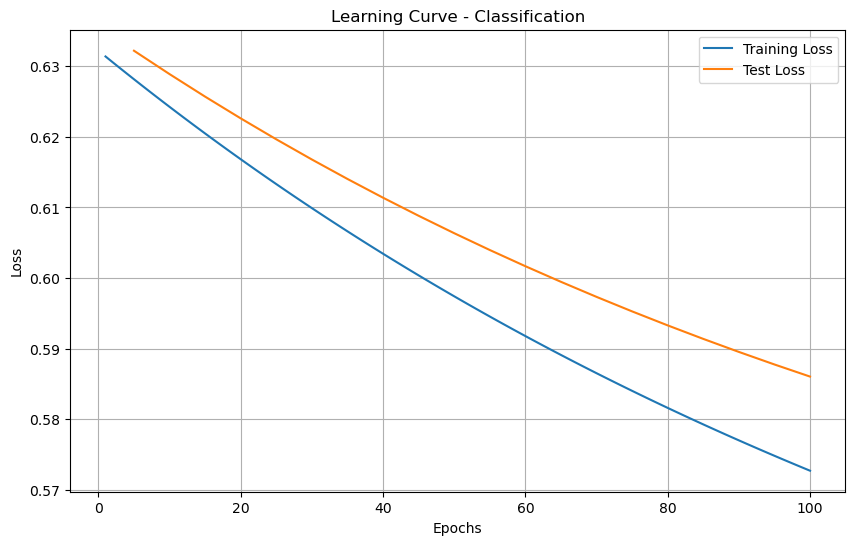

In [38]:
plot_learning_curve(train_losses, test_losses, epochs, model_name="Classification")

#### What It Got Right, and What It Didn’t


In [39]:
X_test_np = X_test.numpy()
y_test_np = y_test.numpy().flatten()
y_pred_class_np = (y_pred.numpy().flatten() > 0.5).astype(int)


results_df = pd.DataFrame(X_test_np, columns=preprocessor.get_feature_names_out())
results_df['actual_smoker'] = y_test_np
results_df['predicted_smoker'] = y_pred_class_np
results_df['correct'] = results_df['actual_smoker'] == results_df['predicted_smoker']


correct_predictions = results_df[results_df['correct'] == True]


incorrect_predictions = results_df[results_df['correct'] == False]


print("Correct Predictions:")
display(correct_predictions.head())

print("\nIncorrect Predictions:")
display(incorrect_predictions.head())

Correct Predictions:


,num__age,num__bmi,num__children,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__sex_male,actual_smoker,predicted_smoker,correct
0,0.696474,-1.336209,-0.909234,0.0,0.0,0.0,1.0,0.0,0,True
1,-0.728120,-0.830321,2.409936,0.0,0.0,1.0,0.0,0.0,0,True
2,0.838934,0.938238,1.580143,1.0,0.0,0.0,0.0,0.0,0,True
4,-0.585661,1.267024,0.750351,0.0,1.0,0.0,1.0,0.0,0,True
5,0.696474,1.122719,0.750351,0.0,1.0,0.0,1.0,0.0,0,True



Incorrect Predictions:


,num__age,num__bmi,num__children,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__sex_male,actual_smoker,predicted_smoker,correct
3,-0.585661,0.611091,1.580143,1.0,0.0,0.0,1.0,1.0,0,False
6,-1.155499,0.984973,0.750351,0.0,0.0,0.0,0.0,1.0,0,False
10,1.551231,-1.569885,-0.909234,1.0,0.0,0.0,0.0,0.0,1,False
11,0.910164,-0.541710,-0.909234,1.0,0.0,0.0,1.0,1.0,0,False
12,-0.514431,0.486464,-0.079442,0.0,0.0,0.0,1.0,1.0,0,False


### **Regression**

In this task, our goal is to predict the insurance charge as a continuous numerical variable.

### **Features Used for Prediction**
We will utilize the following features to make predictions about the insurance charge:

1. **Age**: The age of the individual.
2. **BMI**: Body Mass Index, a measure of body fat based on height and weight.
3. **Children**: The number of children/dependents the individual has.
4. **Smoker**: Whether the individual is a smoker or not (Yes/No).
5. **Region**: The region of residence (e.g., northeast, northwest, southeast, southwest).






#### Model Building Using PyTorch

In [40]:
# The Features that will be passed to the model.
X = df[['age', 'bmi', 'children', 'smoker', 'region','sex']] # Feature set
y = df['charges'] # Target Variable
number_column = X.select_dtypes(include=['int64' , 'float64'])
object_column = X.select_dtypes(include='object')
numerical_features = list(number_column.columns) # We defined all numerical columns as number_column above in the notebook
numerical_transformer = StandardScaler()

# Categorical columns to one-hot encode
categorical_features = X.select_dtypes(include='object').columns  # We defined all categorical columns as object_column above in the notebook
categorical_transformer = OneHotEncoder(drop='first') # Adds new columns to the dataset

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform the entire dataset (excluding the target column, assuming it's 'sex')
X_transformed = preprocessor.fit_transform(X)

# Extract feature names for the transformed DataFrame
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(numerical_names) + list(categorical_names)

df_X_transformed = pd.DataFrame(X_transformed, columns= feature_names)

In [41]:
# The Target Variable
y = np.array(y)
y

array([16884.924 ,  1725.5523,  4449.462 , ...,  1629.8335,  2007.945 ,
       29141.3603])

In [42]:
# normalize the target variable (charges)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

y = y_scaled.ravel()  # flatten back for splitting

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [44]:
# convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # make it 2D
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [45]:
X_train

tensor([[-1.1555, -1.0091, -0.9092,  ...,  0.0000,  0.0000,  1.0000],
        [-1.2980, -0.8065,  0.7504,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.9102,  1.1252,  0.7504,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.3692, -1.4207, -0.0794,  ...,  0.0000,  1.0000,  1.0000],
        [-0.0871, -0.4368,  1.5801,  ...,  0.0000,  1.0000,  0.0000],
        [-0.3007,  0.8521,  0.7504,  ...,  1.0000,  0.0000,  0.0000]])

In [46]:
y_train

tensor([[-0.8990],
        [-0.8260],
        [ 1.6680],
        ...,
        [-0.9346],
        [-0.5062],
        [-0.6148]])

In [47]:
X_train.shape

torch.Size([1069, 8])

In [48]:
# define Perceptron for Regression
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # fully connected layer with 1 output

    def forward(self, x):
        x = self.fc(x)  # no activation for regression
        return x

In [49]:
train_losses = [] # list to hold train loss values for each epoch
test_losses = [] # list to hold test loss values for each epoch

# train one epoch
def train_one_epoch(model, X_train, y_train, criterion, optimizer):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # backward pass and optimization
    loss.backward()
    optimizer.step()

    return loss.item()

# evaluate the model
def evaluate_model(model, X_test, y_test, criterion):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test)

        loss = criterion(outputs, y_test)

        preds = outputs.detach().numpy()
        actuals = y_test.numpy()

        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)

    return loss.item(), mse, mae, r2

# training loop
def train_model(model, X_train, y_train, X_test, y_test, epochs, criterion, optimizer):
    for epoch in range(1, epochs + 1):
        # train the model for one epoch
        train_loss = train_one_epoch(model, X_train, y_train, criterion, optimizer)
        train_losses.append(train_loss) #Append to training loss list

        # print weights and biases every epoch
        weights = model.fc.weight.data
        biases = model.fc.bias.data


        print(f"Epoch {epoch}/{epochs}".center(50, "-"))
        print(f"  Weights: {weights}")
        print(f"  Biases: {biases}")
        print(f"  Training Loss: {train_loss:.4f}\n")

        # evaluate and print metrics every 5 epochs
        if epoch % 5 == 0:
            test_loss, mse, mae, r2 = evaluate_model(
                model, X_test, y_test, criterion
            )
            test_losses.append(test_loss) # append to testing loss list
            print(f"  Testing Loss: {test_loss:.4f}")
            # print evaluation metrics
            print(f"  Evaluation Metrics".center(50, "-"))
            print(f"  Test Loss       : {test_loss:.4f}")
            print(f"  MSE        : {mse:.4f}")
            print(f"  MAE       : {mae:.4f}")
            print(f"  r2          : {r2:.4f}")
            print("-" * 50)


In [50]:
# hyperparameters
lr = 0.01 # learning rate
epochs = 100


input_size = X_train.shape[1]  # the number of columns in your feature set
model = Perceptron(input_size)

# define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(model.parameters(), lr=lr)

train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, criterion=criterion, optimizer=optimizer)

-------------------Epoch 1/100--------------------
  Weights: tensor([[ 0.0488,  0.3261, -0.2774, -0.1666,  0.0170, -0.0139,  0.2537, -0.1563]])
  Biases: tensor([-0.2500])
  Training Loss: 1.2670

-------------------Epoch 2/100--------------------
  Weights: tensor([[ 0.0528,  0.3230, -0.2704, -0.1587,  0.0185, -0.0121,  0.2538, -0.1521]])
  Biases: tensor([-0.2444])
  Training Loss: 1.2471

-------------------Epoch 3/100--------------------
  Weights: tensor([[ 0.0567,  0.3199, -0.2635, -0.1509,  0.0200, -0.0103,  0.2539, -0.1479]])
  Biases: tensor([-0.2389])
  Training Loss: 1.2281

-------------------Epoch 4/100--------------------
  Weights: tensor([[ 0.0606,  0.3169, -0.2568, -0.1432,  0.0214, -0.0086,  0.2540, -0.1439]])
  Biases: tensor([-0.2336])
  Training Loss: 1.2098

-------------------Epoch 5/100--------------------
  Weights: tensor([[ 0.0644,  0.3140, -0.2502, -0.1355,  0.0228, -0.0069,  0.2539, -0.1401]])
  Biases: tensor([-0.2286])
  Training Loss: 1.1922

  Testing 

In [51]:
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_original = scaler_y.inverse_transform(y_pred)  # Revert scaling

    y_test_original = scaler_y.inverse_transform(y_test)  # Ground truth in original scale

    # Calculate regression metrics in the original scale
    mse = mean_squared_error(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 116918207.6448
Mean Absolute Error (MAE): 8211.6946
R-squared (R²): 0.3637


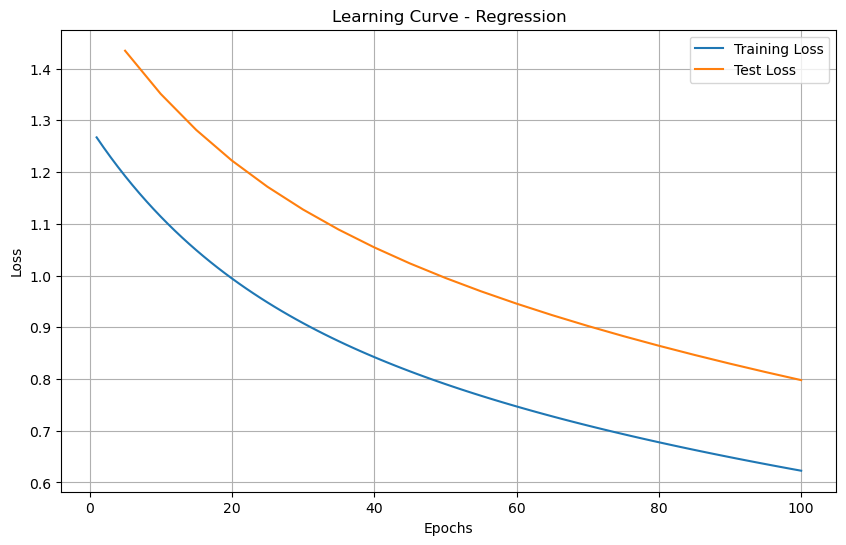

In [52]:
plot_learning_curve(train_losses, test_losses, epochs, model_name="Regression")

#### What It Got Right, and What It Didn’t


In [53]:
X_test_np = X_test.numpy()
y_test_np = y_test.numpy().flatten()
y_pred_np = y_pred.numpy().flatten()

# define a tolerance for acceptable prediction error
tolerance = 0.5  # example: predictions within ±0.5 are considered correct

absolute_error = abs(y_pred_np - y_test_np)

results_df = pd.DataFrame(X_test_np, columns=preprocessor.get_feature_names_out())
results_df['actual'] = y_test_np
results_df['predicted'] = y_pred_np
results_df['absolute_error'] = absolute_error
results_df['correct'] = results_df['absolute_error'] <= tolerance

# rows the model got right
correct_predictions = results_df[results_df['correct'] == True]

# rows the model got wrong
incorrect_predictions = results_df[results_df['correct'] == False]

# display some examples
print("Correct Predictions:")
display(correct_predictions.head())

print("\nIncorrect Predictions:")
display(incorrect_predictions.head())

Correct Predictions:


,num__age,num__bmi,num__children,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__sex_male,actual,predicted,absolute_error,correct
0,0.696474,-1.336209,-0.909234,0.0,0.0,0.0,0.0,1.0,-0.379178,-0.247053,0.132125,True
1,-0.728120,-0.830321,2.409936,0.0,0.0,0.0,1.0,0.0,-0.625340,-0.214914,0.410425,True
2,0.838934,0.938238,1.580143,0.0,1.0,0.0,0.0,0.0,-0.152190,0.302760,0.454950,True
7,-1.226729,-1.043499,-0.909234,0.0,0.0,0.0,1.0,0.0,-0.919280,-0.441985,0.477295,True
9,0.696474,-0.323613,1.580143,0.0,1.0,0.0,0.0,1.0,-0.249027,0.030206,0.279233,True



Incorrect Predictions:


,num__age,num__bmi,num__children,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest,cat__sex_male,actual,predicted,absolute_error,correct
3,-0.585661,0.611091,1.580143,1.0,1.0,0.0,0.0,1.0,2.103716,0.316228,1.787488,False
4,-0.585661,1.267024,0.750351,0.0,0.0,1.0,0.0,1.0,-0.728237,0.003091,0.731329,False
5,0.696474,1.122719,0.750351,0.0,0.0,1.0,0.0,1.0,-0.328306,0.273475,0.601782,False
6,-1.155499,0.984973,0.750351,1.0,0.0,0.0,0.0,0.0,2.084327,0.206410,1.877917,False
8,0.269096,0.816070,-0.079442,0.0,0.0,1.0,0.0,0.0,-0.490127,0.120110,0.610237,False
